In [1]:
library(tidyverse)
library(MASS)
library(glmnet)

source('./simulation_utils.R')

options(repr.plot.width=6, repr.plot.height=4) # plot sizes in this notebook


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
set.seed(645654)

# Fixed parameters in our analysis

In [3]:
d <- 1000 # total number of dimensions
n_cs <- 200 # number of observations in construction sample
n_vs <- 1000 # number of observations in validation sample

# draw X for construction sample. This will be fixed for our analysis 
covar_x <- diag(d) * 1. # true covariance of our draws of X
mu_x <- rep(0, d) # mean of our draws of X

x_cs_ <- mvrnorm(n_cs, mu_x, covar_x) 
x_cs <- scale(x_cs_, scale = FALSE, center = TRUE) # center the columns of X

# regression coefficients
beta_full <- rnorm(d, 0, 1)


s <- 950 # sparsity
sigma <- 5 # standard error of noise

# One round of analysis

## Draw data: 

In [4]:
data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)

## run lasso

In [5]:
lasso_fit <- glmnet(data$x_cs, data$y_cs)
lambdas_path <- lasso_fit$lambda # the lambdas the path examined

In [6]:
lambdas <- c(lambdas_path)
n_lambdas <- length(lambdas)

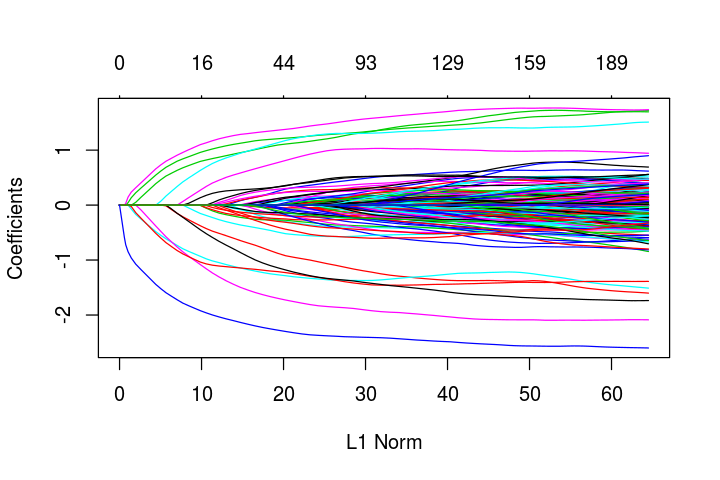

In [7]:
plot(lasso_fit)

In [8]:
predicted_cs_y <- predict(lasso_fit, x = data$x_cs, y = data$y_cs, newx = data$x_cs, s = lambdas, exact = TRUE)
predicted_vs_y <- predict(lasso_fit, x = data$x_cs, y = data$y_cs, newx = data$x_vs, s = lambdas, exact = TRUE)

## Select lambda using cross-validation

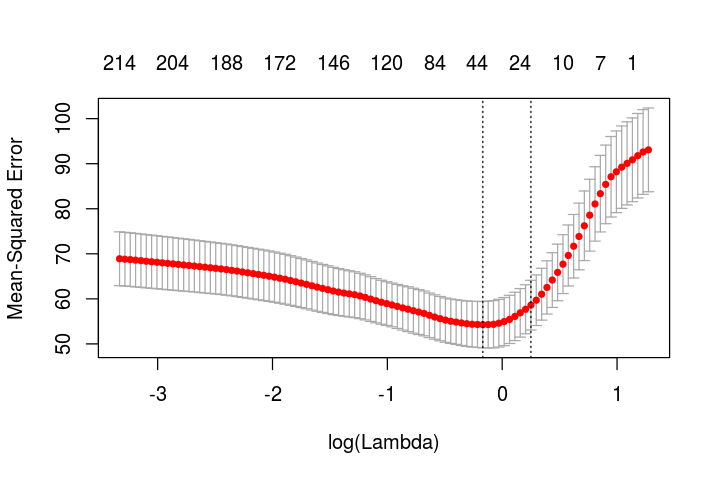

In [9]:
lambda_cv <- choose_lambda_cv(data$x_cs, data$y_cs, lambdas, plot = TRUE)

In [10]:
print(log(lambda_cv))

[1] -0.1686234


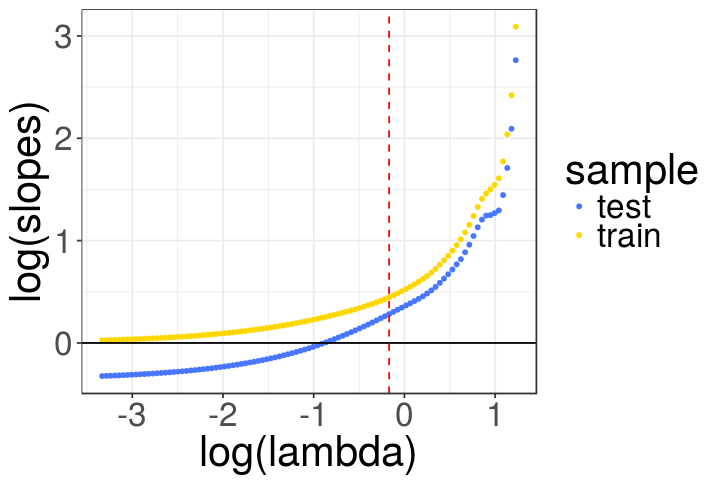

In [11]:
cs_slopes <- get_slope(predicted_cs_y, data$y_cs)
vs_slopes <- get_slope(predicted_vs_y, data$y_vs)

data.frame(slopes = c(as.vector(cs_slopes), as.vector(vs_slopes)), 
           lambda = c(lambdas, lambdas), 
           sample = c(rep('train', n_lambdas), rep('test', n_lambdas))) %>%
    filter(is.finite(slopes)) %>%
    ggplot() + geom_point(aes(x = log(lambda), y = log(slopes), color = sample), size = 1.0) + 
        scale_color_manual(values=c("royalblue1", "gold")) + 
        geom_hline(yintercept = 0) + geom_vline(xintercept = log(lambda_cv), color = 'red', linetype = 'dashed') + 
        theme_bw() + 
    theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))

ggsave('../writing/lasso_figures/slope_vs_lambda.png', width = 9, height = 6)

In [12]:
# slope is observed y on predicted y

In [13]:
# for small lambda we get the regression case again
# should should be less than 1 a la Copas
vs_slopes[which.min(lambdas)]

[1] 0.7236788

In [14]:
# should be close to 1
# we should be able to fit the line perfectly with enough coefficients
cs_slopes[which.min(lambdas)]

[1] 1.026261

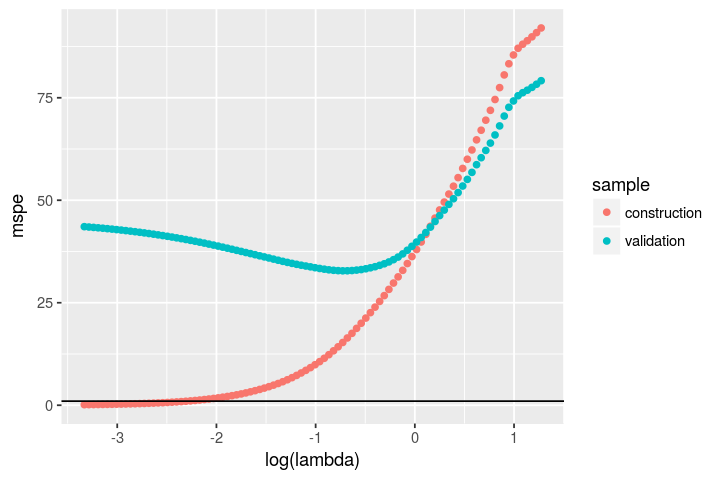

In [15]:
cs_mspe <- get_mspe(predicted_cs_y, data$y_cs)
vs_mspe <- get_mspe(predicted_vs_y, data$y_vs)

data.frame(mspe = c(as.vector(cs_mspe), as.vector(vs_mspe)), 
           lambda = c(lambdas, lambdas), 
           sample = c(rep('construction', n_lambdas), rep('validation', n_lambdas))) %>%
    filter(is.finite(mspe)) %>%
    ggplot() + geom_point(aes(x = log(lambda), y = mspe, color = sample)) + 
        geom_hline(yintercept = 1.0)

## Select lambda using AIC and BIC

In [16]:
ic_results <- choose_lambda_ic(data$x_cs, data$y_cs, lambdas)

In [17]:
log(ic_results$lambda_aic)

[1] -3.331771

In [18]:
log(ic_results$lambda_bic)

[1] -3.331771

In [19]:
# these values are really shitty ... so aic and bic basically tell us we need to just run regression?

## Select lambda using cross-validation

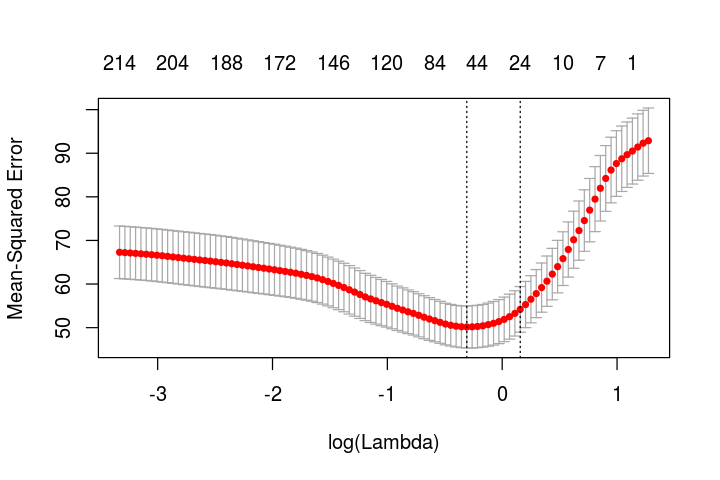

In [20]:
lambda_cv <- choose_lambda_cv(data$x_cs, data$y_cs, lambdas, plot = TRUE)

In [21]:
print(log(lambda_cv))

[1] -0.308174


# We explore the distribution of slopes over repeated trials

In [ ]:
n_trials <- 100
# grab a snack this takes a few minutes

lambdas_vs <- rep(0, n_trials)
cv_slope_cs <- rep(0, n_trials)
cv_slope_vs <- rep(0, n_trials)

t0 <- proc.time()
for(i in 1:n_trials){
    data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)  # draw data
    lasso_fit_cv <- cv.glmnet(data$x_cs, data$y_cs) # get lambda
    min_lambda <- lasso_fit_cv$lambda.min
    
    # predict on training set
    y_pred_cs <- predict(lasso_fit_cv, newx = data$x_cs, s = min_lambda)    
    
    # predict on validation set
    y_pred_vs <- predict(lasso_fit_cv, newx = data$x_vs, s = min_lambda)    
    
    cv_slope_cs[i] <- drop(get_slope(y_pred_cs, data$y_cs))
    cv_slope_vs[i] <- drop(get_slope(y_pred_vs, data$y_vs))
    
    lambdas_vs[i] <- min_lambda
    
}
t1 <- proc.time() - t0
print(t1 - t0)

In [ ]:
data.frame(slopes = c(cv_slope_cs, cv_slope_vs), 
          sample = c(rep('construction', n_trials), rep('validation', n_trials))) %>%
    ggplot() + geom_histogram(aes(x = slopes, fill = sample, color = sample),
                              binwidth = 0.1, position = 'identity', alpha = 0.2)

In [ ]:
# TODO: 
# see how this varies as a function of 1. Sparsity and 2. Signal-to-noise ratio
# now run COPAS shrinkage (maybe just a second CV step) to fix the scaling issue

# Two step lasso

In [22]:
# we use CV to jointly choose lambda and K
k_range <- seq(0.5, 1.5, by = 0.05)
joint_cv_results <- choose_joint_lambda_k(data$x_cs, data$y_cs, lambdas, k_range)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21


In [23]:
# compare lasso predictions, only choosing lambda vs. k and lambda

# choosing lambda only
lasso_cv_fit <- cv.glmnet(data$x_cs, data$y_cs)
lasso_cv_pred <- predict(lasso_cv_fit, newx = data$x_vs, s = lasso_cv_fit$lambda.min)

# choose both lambda and k
lasso_joint_cv_pred <- joint_cv_results$k * 
    predict(lasso_cv_fit, newx = data$x_vs, s = joint_cv_results$lambda)

In [24]:
lasso_cv_fit$lambda.min

[1] 0.7013902

In [25]:
print(joint_cv_results$lambda)
print(joint_cv_results$k)

[1] 0.9271966
[1] 1.45


In [26]:
# compare MSPEs: 
cat('lasso mspe: ', get_mspe(lasso_cv_pred, data$y_vs), '\n')
cat('two-step mspe: ', get_mspe(lasso_joint_cv_pred, data$y_vs))

lasso mspe:  34.12229 
two-step mspe:  34.38698

In [27]:
# slopes?
cat('lasso mspe: ', get_slope(lasso_cv_pred, data$y_vs), '\n')
cat('two-step mspe: ', get_slope(lasso_joint_cv_pred, data$y_vs))

lasso mspe:  1.220812 
two-step mspe:  0.9534428

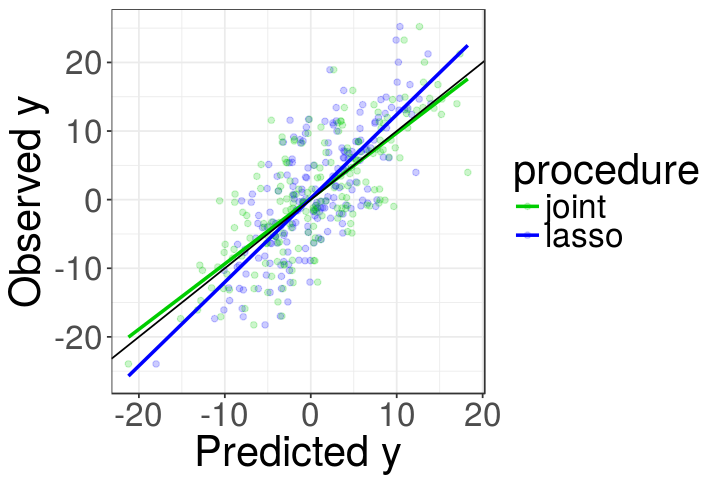

In [29]:
data.frame(y_obs = data$y_vs, 
           lasso = as.vector(lasso_cv_pred), 
           joint = as.vector(lasso_joint_cv_pred)) %>%
    gather(key = 'procedure', value = 'y_pred', lasso, joint) %>% 
    ggplot() + geom_point(aes(x = y_pred, y = y_obs, colour = procedure), alpha = 0.2) + 
                stat_smooth(aes(x = y_pred, y = y_obs, colour = procedure), 
                           linetype = 'solid', method = 'lm', se = FALSE, fullrange = TRUE) + 
        geom_abline(slope = 1) + scale_color_manual(values=c("green3", "blue")) + 
        xlab('Predicted y') + ylab('Observed y') + 
        theme_bw() + 
    theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))
        
ggsave('../writing/lasso_figures/obs_y_vs_pred.png', width = 9, height = 6)

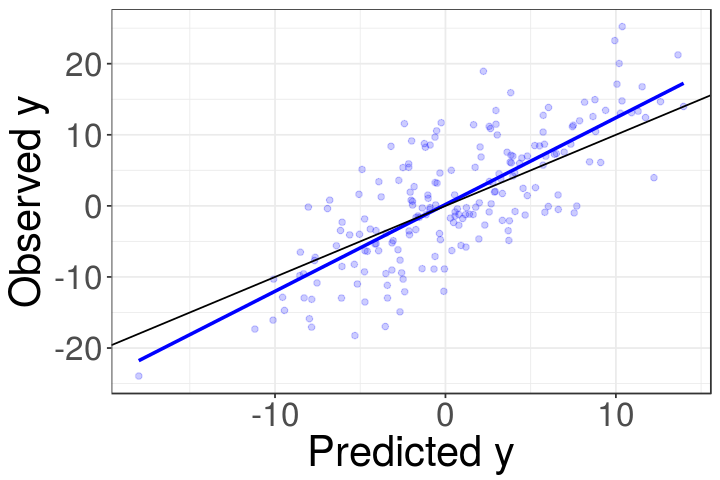

In [31]:
data.frame(y_obs = data$y_vs, 
           lasso = as.vector(lasso_cv_pred)) %>%
    gather(key = 'procedure', value = 'y_pred', lasso) %>% 
    ggplot() + geom_point(aes(x = y_pred, y = y_obs, colour = procedure), alpha = 0.2) + 
                stat_smooth(aes(x = y_pred, y = y_obs, colour = procedure), 
                           linetype = 'solid', method = 'lm', se = FALSE, fullrange = TRUE) + 
        geom_abline(slope = 1) + scale_color_manual(values=c("blue")) + 
        xlab('Predicted y') + ylab('Observed y') + 
        theme_bw() + theme(legend.position="none") + 
    theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))
        
ggsave('../writing/lasso_figures/obs_y_vs_pred2.png', width = 9, height = 6)

In [30]:
# Again run this two-step procedure for a number of trials like before 

In [31]:
n_trials <- 100
# get another snack ... 

# two rows, n_trials columns
# first row stores the k's, second row stores the lambdas
results_mat <- matrix(0, ncol = n_trials, nrow = 2)
rownames(results_mat) <- c('k', 'lambda')

joint_slope_vs <- rep(0, n_trials)

t0 <- proc.time()

lasso_fit <- glmnet(data$x_cs, data$y_cs)

for(i in 1:n_trials){
    data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)  # draw data
    
    # choose lambda and k
    joint_results <- choose_joint_lambda_k(data$x_cs, data$y_cs, lambdas, k_range)
    results_mat[1, i] <- joint_results$k
    results_mat[2, i] <- joint_results$lambda
        
    # predict on validation set
    y_pred_vs <- predict(lasso_fit, newx = data$x_vs, s = joint_results$lambda) * joint_results$k 
    
    # slope_cs[i] <- drop(get_slope(y_pred_cs, data$y_cs))
    joint_slope_vs[i] <- drop(get_slope(y_pred_vs, data$y_vs))
        
}
t1 <- proc.time() - t0
print(t1 - t0)

    user   system  elapsed 
1095.600    1.257 1097.135 


In [32]:
save.image(file = './Apr15_results.RData')

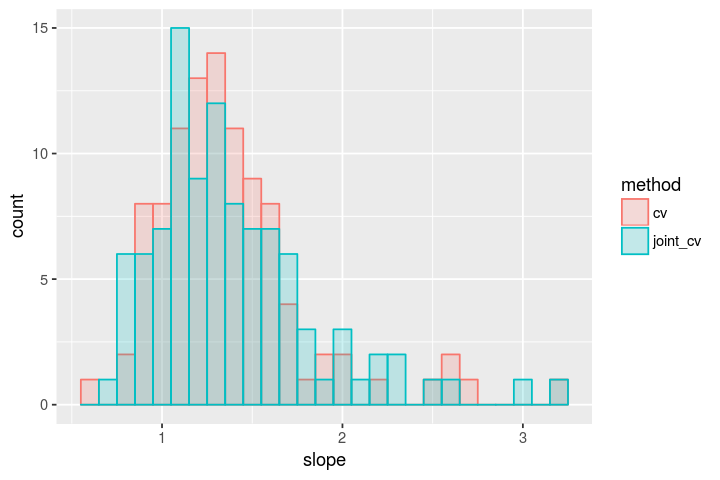

In [33]:
data.frame(cv = cv_slope_vs, joint_cv = joint_slope_vs) %>% 
    gather(key = 'method', value = 'slope') %>%
    ggplot() + geom_histogram(aes(x = slope, color = method, fill = method), 
                              position = 'identity', alpha = 0.2, binwidth = 0.1)